# Loading the Wildfire Dataset
This notebook has been built to showcase a way to open and manage the Wildfire Dataset found [here](https://www.kaggle.com/datasets/behroozsohrabi/us-wildfire-records-6th-edition?resource=download) from Kaggle. You may need an acccount to acccess and download the data. Try to download it and save it to a suitable location.

The original source of the data is:

*Short, Karen C. 2022. Spatial wildfire occurrence data for the United States, 1992-2020 [FPA_FOD_20221014]. 6th Edition. Fort Collins, CO: Forest Service Research Data Archive. https://doi.org/10.2737/RDS-2013-0009.6*

You may wish to study the above source to gain some insight to the data, for example, there's cxomments on the quality anf decisions made to produce such a set [here](https://www.fs.usda.gov/rds/archive/products/RDS-2013-0009.6/_metadata_RDS-2013-0009.6.html). 

You are welcome to use any of the code showcased below for your work. It may be that you need to tweak this process in your own work, and that's fine! Use it as you see fit. Remember to cite the owner of the dataset, Karen Short, in your thesis.

### Import Modules

We're going to start by importing necssarry modules for this example. I'm using some custom classes and utilities that are located in the `resources` folder of this repo. I've tried to make sure that this code will work on many machines, but you may run into some issues. Feel free to reach out if you have any!

In [1]:
import logging
import calendar
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import swifter
from typing import List
from utils import setup_logging
from dataloaders.wildfireloader import WildFireDataLoader

I'm also going to setup the `logging` library here with a simple utility function - it's a cleaner and handier way to provide outputs from code - providing more verbose output than a `print` statement.

In [2]:
_ = setup_logging(debug=False)

Now I'm going to setup an instance of the `WildFireDataLoader` class. This class has been built with some methods to help clean and preprocess the dataset from Kaggle. I hope you find it useful!

In [3]:
wfdl = WildFireDataLoader(
    datadir="/Users/alex/gitrepos/IRP-help/data/data.sqlite",
    start_date="20180112",
    end_date="20180412",
    truth_fields=[""],
    input_fields=None,
)

### A Simple Guide to Queries
If you check the file extension above, you'll see that the dataset is a type of SQL database. If you've not encountered SQL before it can be a little daunting. I've written some example queries and uses below to help - using the `WildFireDataLoader`'s `load_dataset_from_query` method.

In [4]:
example_query = "SELECT FIRE_YEAR, \
                    count(1) as nr_of_fires, \
                    sum(FIRE_SIZE) as total_fire_size, \
                    avg(FIRE_SIZE) AS average_fire_size  \
                    from Fires GROUP BY FIRE_YEAR;"
wfdl.load_dataframe_from_query(query=example_query)

In [5]:
wfdl._df.head()

,FIRE_YEAR,nr_of_fires,total_fire_size,average_fire_size
0,1992,67961,2.199923e+06,32.370367
1,1993,61975,2.191587e+06,35.362437
2,1994,75932,4.115582e+06,54.200895
3,1995,71440,2.049553e+06,28.689154
4,1996,75561,6.004833e+06,79.470008


So what was that all about? The query set as the variable `example_query` is used to request data from the SQL database. Here the database engine reads and processes the query, then searches the database for the data that matches the criteria specified in the query.

The query here can be broken down as:
- `SELECT FIRE_YEAR`: Specifies a columns to be returned in the resultant dataframe. In this case, we want to retrieve the year in which each fire occurred.

- `count(1) as nr_of_fires`: Uses the `count()` function to calculate the number of fires that occurred in each year. The result of this calculation is assigned to an alias called `nr_of_fires`.

- `sum(FIRE_SIZE) as total_fire_size`: Uses the `sum()` function to calculate the total size of all fires that occurred in each year. The result of this calculation is assigned to an alias called `total_fire_size`.

- `avg(FIRE_SIZE) AS average_fire_size`: Uses the `avg()` function to calculate the average size of all fires that occurred in each year. The result of this calculation is assigned to an alias called `average_fire_size`.

- `from Fires`: Specifies the table from which to retrieve the data. In this case, the table is called `Fires`.

- `GROUP BY FIRE_YEAR`: This part of the query groups the results by the year in which the fires occurred. This means that the statistical information retrieved by the query will be broken down by year, so we can see how many fires occurred, how large they were, and what the average size was for each year!

### Dataset metadata
If you'd like to inspect the table a bit to build some contextual knowledge around the queries, I've written some simple utility functions which are showcased below.

In [6]:
table_names = wfdl.extract_table_names()
logging.info("Table names that are present in the dataset are: %s", table_names)

[2023-04-07T15:57:18Z] INFO: Table names that are present in the dataset are: ['Fires']


So, we know there's only one table present in this dataset to extract data from. We can also discover this by checking the [Kaggle metadata](https://www.kaggle.com/datasets/behroozsohrabi/us-wildfire-records-6th-edition?resource=download) online. Same for the column names below:

In [7]:
for table in table_names:
    cols = wfdl.extract_colun_names_from_table(table_name=table)
    logging.info("Columns under table %s are %s", table, cols)

[2023-04-07T15:57:19Z] INFO: Columns under table Fires are ['OBJECTID', 'Shape', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM', 'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID', 'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT', 'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID', 'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME', 'ICS_209_PLUS_INCIDENT_JOIN_ID', 'ICS_209_PLUS_COMPLEX_JOIN_ID', 'MTBS_ID', 'MTBS_FIRE_NAME', 'COMPLEX_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY', 'DISCOVERY_TIME', 'NWCG_CAUSE_CLASSIFICATION', 'NWCG_GENERAL_CAUSE', 'NWCG_CAUSE_AGE_CATEGORY', 'CONT_DATE', 'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE', 'LONGITUDE', 'OWNER_DESCR', 'STATE', 'COUNTY', 'FIPS_CODE', 'FIPS_NAME']


SQL is all well and good, but we probably want to convert it into a more Python friendly object for interacting with other functionalities (such as creating a dataset for a Python based ML-model). Let's do that now by converting into a `pandas` dataframe.

pro tip, watch for commas at the end of your queries, the exception handling isn't super verbose, so you'll just receive a syntax error with little explanation.

That's quite a lot of date that we're playing with there, so let's limit it instead to 6 months to speed things up.

In [8]:
year = 2018
example_query = f"SELECT \
    FPA_ID AS fire_id, \
    (DISCOVERY_DATE || ' ' || DISCOVERY_TIME) AS timestamp, \
    LATITUDE AS lat,\
    LONGITUDE AS lon,\
    FIRE_SIZE AS fire_size_acres, \
    FIRE_SIZE_CLASS AS fire_size_class, \
    FIRE_CODE AS fire_code, \
    NWCG_CAUSE_CLASSIFICATION As cause_class \
    FROM Fires \
    WHERE substr(DISCOVERY_DATE, -4) = '{year}';"

In [9]:
wfdl.load_dataframe_from_query(query=example_query)

Let's load in this dataframe with the timestamp column being converted to a pandas object, this will help us merge with weather data later. We can do this using the `to_pandas_df` method.

In [10]:
df = wfdl.to_pandas_df(datetime_cols=["timestamp"])

[2023-04-07T15:57:21Z] INFO: Processing pandas datetimes, this might take a few minutes...


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80860 entries, 0 to 80859
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   fire_id          80860 non-null  object        
 1   timestamp        80860 non-null  datetime64[ns]
 2   lat              80860 non-null  float64       
 3   lon              80860 non-null  float64       
 4   fire_size_acres  80860 non-null  float64       
 5   fire_size_class  80860 non-null  object        
 6   fire_code        80860 non-null  object        
 7   cause_class      80860 non-null  object        
dtypes: datetime64[ns](1), float64(3), object(4)
memory usage: 4.9+ MB


We have a dataframe! If we do some plotting I bet we'll find some issues with the dataset that will need addressing before training a model, so we'll have a visual inspection next.

Feel free to make a new query with your own criteria to build a new dataframe - maybe I've missed a column you think could be useful to have as a predictor! You can pull off quite a lot of cool stuff with just the query if you know how (I'll admit my SQL knowledge is poor) - which might let you generate dervied columns directly in the query. Sort of like the example at the top of the notebook!

Remember that I've only extracted a year using that query above, if you want more data you can remvoe that last line, or tweak it for a longer range!

### Plotting the Data

Lets do a spatial plot to understand the distribution of wildfires over the USA. We'll use the `Basemap` library in Python to do this. There's newer packages like `seaborne`, `geopandas` and more.

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

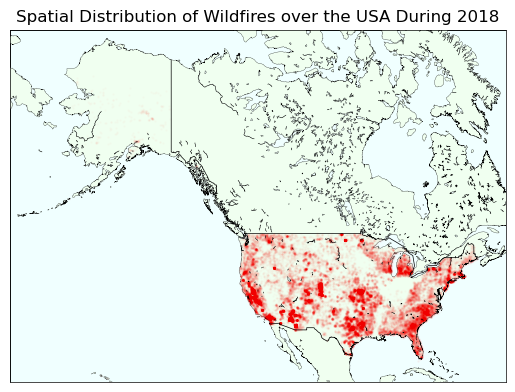

In [13]:
us_map = Basemap(llcrnrlat=20, llcrnrlon=-180, urcrnrlat=72, urcrnrlon=-60, projection="merc", resolution="i")
us_map.drawcoastlines(linewidth=0.2)
us_map.drawcountries()
us_map.fillcontinents(color="honeydew", lake_color="azure")
us_map.drawmapboundary(linewidth=0.5, fill_color="azure")
x, y = us_map(df["lon"].values, df["lat"].values)
us_map.scatter(x=x, y=y, s=1, alpha=0.01, color="red")
plt.title(f"Spatial Distribution of Wildfires over the USA During {year}")
plt.show()

Okay, there's some things to note:
- Alaska appears to have less wildfires in 2018. To save on data resources, we might want to constrain the problem to just the mainland USA.
- These are point observations

[2023-04-07T15:57:38Z] INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2023-04-07T15:57:38Z] INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Text(0.5, 1.0, 'Histogram of wildfires over the year of 2018')

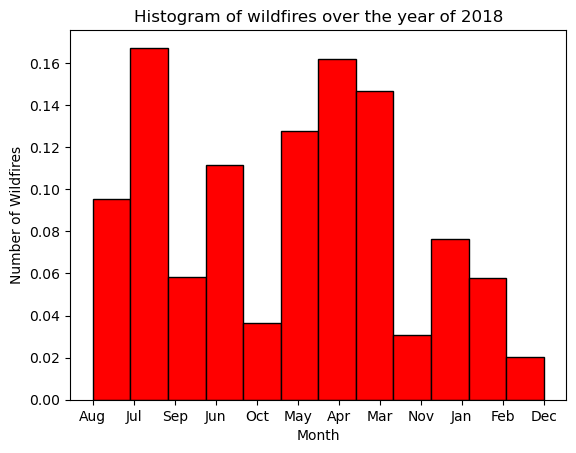

In [14]:
df["month"] = [calendar.month_abbr[x] for x in pd.DatetimeIndex(df["timestamp"]).month]
fig, ax = plt.subplots()
df["month"].hist(bins=len(df["month"].unique()), color="red", density=True, ax=ax, rwidth=1, edgecolor="black", grid=False)
ax.set_xlabel("Month")
ax.set_ylabel("Number of Wildfires")
ax.set_title(f"Histogram of wildfires over the year of {year}")

## Binning the Data
Something to think about, is that this data is point observations, as-in a specific event (and also a specific time). Most weather data you work with won't be like that - so to create a dataset we're going to need to bin this wildfire sat spatially and temporally.

Let's assume you've chosen the ERA-5 reanalysis as your training data, that would mean we need to:
- bin to 0.1 degrees in lat and lon.
- round our time signals to the nearest time.

ERA-5 is available hourly, but if we pull all that data down, that's going to be a huuuuge dataset. Let's stick to 6hrly intervals for now.

Let's define some functions to do this for us.

In [15]:
def bin_columns_by_uniform_step(df: pd.DataFrame, column_names: List[str], bin_size: float = 0.1) -> pd.DataFrame:
    """
    Rounds a provided list of column names to a given step size. Usable on both datetime and numeric columns.

    Args:
        dataframe (pd.DataFrame): An AIS dataframe to be binned.
        column_names (list): A list of column names to round. Note that provided column names must be of the same type.
        bin_size (float): The resolution of the bins.

    Returns:
        pd.DataFrame: A dataframe with given columns rounded/binned.
    """

    column_datatypes = df[column_names].dtypes

    if not (column_datatypes == column_datatypes[0]).all(0):
        raise TypeError("Unable to perform this operation on multiple types. Provide differently typed columns seperately.")

    df.loc[:, column_names] = df.loc[:, column_names].swifter.apply(lambda value: bin_size * np.round(value / bin_size))

    return df

In [16]:
def round_to_nearest_hour(df: pd.DataFrame, column_names: List[str], temporal_rounding_h: int = 1) -> pd.DataFrame:
    """
    Rounds

    Args:
        df (pd.DataFrame): _description_
        column_names (List[str]): _description_
        temporal_rounding_h (int, optional): _description_. Defaults to 1.

    Returns:
        pd.DataFrame: _description_
    """
    column_datatypes = df[column_names].dtypes
    if not (column_datatypes == column_datatypes[0]).all(0):
        raise TypeError("Unable to perform this operation on multiple types. Provide differently typed columns seperately.")
    for column in column_names:
        df[column] = df[column].dt.round(f"{temporal_rounding_h}H")

    return df

In [17]:
df = bin_columns_by_uniform_step(df, column_names=["lat", "lon"], bin_size=0.1)

In [18]:
df = round_to_nearest_hour(df, column_names=["timestamp"], temporal_rounding_h=6)

In [19]:
df.head()

,fire_id,timestamp,lat,lon,fire_size_acres,fire_size_class,fire_code,cause_class,month
0,FS-6911076,2018-08-22 18:00:00,46.3,-114.4,0.1,A,EKS4,Natural,Aug
1,FS-6908885,2018-07-26 12:00:00,46.4,-113.9,0.1,A,L1RX,Human,Jul
2,FS-6898061,2018-09-21 12:00:00,46.2,-114.3,1.0,B,L49X,Human,Sep
3,FS-6890683,2018-08-17 18:00:00,45.8,-114.0,0.1,A,EKS4,Natural,Aug
4,FS-6888073,2018-08-12 12:00:00,46.0,-113.8,0.1,A,EKS4,Natural,Aug


## Saving the dataset
After some exploration and tweaks, you may want to save the dataset, so that you don't have to re-load from the SQL database every time. 

In [20]:
wfdl.save_dataframe_as_parquet()

[2023-04-07T15:57:40Z] INFO: Saving dataframe to: /Users/alex/gitrepos/IRP-help/data/export.parquet.gzip


We can reload this file whenever we need using the following:

In [22]:
opened_df = pd.read_parquet("/Users/alex/gitrepos/IRP-help/data/export.parquet.gzip")
opened_df.head()

,fire_id,timestamp,lat,lon,fire_size_acres,fire_size_class,fire_code,cause_class,month
0,FS-6911076,2018-08-22 18:00:00,46.3,-114.4,0.1,A,EKS4,Natural,Aug
1,FS-6908885,2018-07-26 12:00:00,46.4,-113.9,0.1,A,L1RX,Human,Jul
2,FS-6898061,2018-09-21 12:00:00,46.2,-114.3,1.0,B,L49X,Human,Sep
3,FS-6890683,2018-08-17 18:00:00,45.8,-114.0,0.1,A,EKS4,Natural,Aug
4,FS-6888073,2018-08-12 12:00:00,46.0,-113.8,0.1,A,EKS4,Natural,Aug


That's all! You'll need to merge this set with weather data, which I'll cover in the ERA5 notebook. If you need a hand with any of this, feel free to reach out!